# Estimate p-Thyrosim parameters

+ **5/13/2020**: Things I tried for past 2 weeks didn't really work. Now I will start with the best model we have (obtained on 4/28) and try to fix the problems with it. Namely, the T3 values in Blakesley are too low. We fix this issue by fitting S3, k05, k3dissolve and k3excrete. We do not fit k3absorb because it is a parameter adjustable on Thyrosim website (default 0.88). 


+ **4/30/2020 notes**: Blakesley T3 fit keep screwing up. Thus we start fitting T3 secretion and excretion rate. This is achieved by making dial part of the p parameter.


+ **4/21/2020 notes**: In `problem_diagnostics.ipynb` and `schneider_avg_predicted_dose.svg`, predicted dose for skinnier patients are overestimated. Plotting a few normal patients reveal that while ~2.3ug/kg T4 is sufficient, ~1.8ug give rise to large (~4.5) TSH values. Perhaps scaling the error function by 0.22 introduced in 3/29 is causing this screw as smaller dose is forced to approach TSH 4.5. Back then, we were fitting k21 and k31 which we shouldn't be. Therefore we try getting rid of the scaling. Also, we try **include Blakesley's T3 data in fitting**.


+ **4/14/2020 notes**: Realized we shouldn't be fitting k21 and k31. Instead, fit k02 and k05 because they are the terms that handle T4/T3 eliminations. Also, use absolute error in objective instead of scaled error, because otherwise one of the hill coefficients will want to blowup to infinity. 

    Furthremore, Mauricio's python notebook for Schneider's data shows that:
    + We are underpredicting doses for males and overpredicting for females. **This suggests a problem with our model's sex parametrization that is somewhat deeper than fitting**
    

+ **3/29/2020 notes**: According to `problem_diagnostics.ipynb`, the current fit improves error by making every dose achieve euthyroidism. This leads to severely underpredicted T4 dose: median predicted euthyroid dose is ~0.5ug/kg while in real data it should be ~1.6. The reason might be because we have no schneider patients that's is supposed to have a *"high TSH level"*. To solve this problem, we will assign an error of 
$$\log(4.5 / TSH) / 0.22$$
for patients whose predicted TSH is within normal range but whose initial dose is smaller than their euthyroid dose (i.e. we know the initial dose is insufficient). Division by 0.22 is because only 91 / 400 patients satisfy this criteria, so we scale up their error proportion.

In [1]:
using Revise
using Distributed
addprocs(8)

@everywhere begin
    using DifferentialEquations
    using Thyrosim
    using DiffEqCallbacks
    using DiffEqParamEstim
    using SharedArrays
end

using Plots
using Optim
using Statistics

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency MultiScaleArrays [f9640e96-87f6-5992-9c3b-0743c6a49ffa] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency MultiScaleArrays [f9640e96-87f6-5992-9c3b-0743c6a49ffa] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
│   exception = Required dependency MultiScaleArrays [f9640e96-87f6-5992-9c3b-0743c6a49ffa] failed to load from a cache file.
└ @ Base loadin

      From worker 2:	┌ Warning: Module DifferentialEquations with build ID 68808891492621 is missing from the cache.
      From worker 2:	│ This may mean DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] does not support precompilation but is imported by a module that does.
      From worker 2:	└ @ Base loading.jl:1011
      From worker 7:	┌ Warning: Module DifferentialEquations with build ID 68810828201277 is missing from the cache.
      From worker 7:	│ This may mean DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] does not support precompilation but is imported by a module that does.
      From worker 7:	└ @ Base loading.jl:1011
      From worker 8:	┌ Warning: Module DifferentialEquations with build ID 68811343734577 is missing from the cache.
      From worker 8:	│ This may mean DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] does not support precompilation but is imported by a module that does.
      From worker 8:	└ @ Base loading.jl:1011
    

┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


# Define error functions for the 3 datasets

## Blakesley

Used to fit TSH and T4 values. 

## Jonklaas

Used to fit T3 values.

## Schneider

Used as model verification. We simulate patients according to the number of days the patient achieved euthyrodism using the given dose, then calculate if their TSH levels are within [0.45, 4.5] mIU/ml.

## Parameter definition:
- `p[55]:` Daily T4 oral dose
- `p[56]:` Daily T3 oral dose

## Error definition:

For Blakesley and Jonklaas data, we calculate the residual loss between thyrosim and data. For Schneider data, the loss is defined as:

+ When given an euthyroid T4 dose, if any TSH values $\notin [0.5, 4.5]$ in the last 24h of simulation, then error + 1 (i.e. **patients receiving correct dose should have normal TSH**)
+ When given the initial T4 dose, if the initial T4 dose is not equal to euthyroid T4 dose, and all TSH values $\in [0.5, 4.5]$, then error + 1 (i.e. **patients not receiving correct dose should NOT have normal TSH**)

## Objective function 
+ `current_iter` stores only the parameters that are being optimized. 
+ `p` stores the full parameter vector. It is initialized separately for each patient and contains the parameters in `current_iter`. We update these parameters using `fitting_index`. 

## Import data and initial conditions

In [3]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

In [71]:
function objective(
    p_being_optimized::Vector, 
    fitting_index::SharedArray, 
    blakesley_time::Matrix,
    blakesley_my400_data::Matrix, 
    blakesley_my450_data::Matrix, 
    blakesley_my600_data::Matrix,
    jonklaas_time::Vector, 
    jonklaas_patient_t4::Matrix, 
    jonklaas_patient_t3::Matrix, 
    jonklaas_patient_tsh::Matrix, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    schneider_height::SharedArray, 
    schneider_weight::SharedArray, 
    schneider_sex::SharedArray, 
    schneider_tspan::SharedArray, 
    schneider_init_tsh::SharedArray, 
    schneider_euthy_dose::SharedArray, 
    schneider_init_dose::SharedArray;      
    verbose::Bool = false #set to true to display intermediate errors
    )
    
    total_scale_error = 0.0
    # quick return
    any(p_being_optimized .< 0.0) && return Inf
    #
    # Blakesley
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    p_400 = p_450 = p_600 = copy(p)
    T4_init_400, T3_init_400, TSH_init_400 = blakesley_my400_data[1, :]
    T4_init_450, T3_init_450, TSH_init_450 = blakesley_my450_data[1, :]
    T4_init_600, T3_init_600, TSH_init_600 = blakesley_my600_data[1, :]
    # solve different ODE problems for varying doses
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    set_patient_ic!(ic, p_400, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
    set_patient_ic!(ic, p_450, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
    set_patient_ic!(ic, p_600, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 4, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 4, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 4, 7])
#     T4_error = blakesley_t4_error(sol_400, blakesley_time, blakesley_my400_data, p[47]) + 
#                blakesley_t4_error(sol_450, blakesley_time, blakesley_my450_data, p[47]) + 
#                blakesley_t4_error(sol_600, blakesley_time, blakesley_my600_data, p[47])
    T3_error = blakesley_t3_error(sol_400, blakesley_time, blakesley_my400_data, p[47]) + 
               blakesley_t3_error(sol_450, blakesley_time, blakesley_my450_data, p[47]) + 
               blakesley_t3_error(sol_600, blakesley_time, blakesley_my600_data, p[47])
#     TSH_error = blakesley_tsh_error(sol_400, blakesley_time, blakesley_my400_data, p[48]) + 
#                 blakesley_tsh_error(sol_450, blakesley_time, blakesley_my450_data, p[48]) + 
#                 blakesley_tsh_error(sol_600, blakesley_time, blakesley_my600_data, p[48])
    blakesley_err = T3_error
    scaled_blakesley_error = blakesley_err / 99 # divide total error by number of data 198 = T4 and TSH, 297 = T4,T3,TSH 
    verbose && println("blakesley error: unscaled = $blakesley_err, scaled = $scaled_blakesley_error")
    total_scale_error += scaled_blakesley_error
    #
    # Jonklaas
    #
#     tspan = (0.0, 8.0)
#     cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
#     jonklaas_err = 0.0
#     for i in 1:size(jonklaas_patient_dose, 1)
#         # initialize ODE problem for patient 1
#         height, weight, sex = jonklaas_patient_param[i, :]
#         T4init, T3init, TSHinit = jonklaas_patient_t4[i, 1], jonklaas_patient_t3[i, 1], jonklaas_patient_tsh[i, 1]
#         ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
#         set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
#         # set parameters being fitted
#         p[fitting_index] .= p_being_optimized
#         # solve different ODE problems for varying doses
#         p[56] = jonklaas_patient_dose[i] / 651.0
#         prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
#         sol  = solve(prob, save_idxs=4)
#         jonklaas_err += jonklaas_error(sol, jonklaas_time, jonklaas_patient_t3[i, :], p[47])
#     end
#     jonklaas_err *= 10.0 # scale by 10 to match schneider&blakesley error range
#     scaled_jonklaas_error = jonklaas_err / 135.0
#     verbose && println("jonklaas error: unscaled = $jonklaas_err, scaled = $scaled_jonklaas_error")
#     total_scale_error += scaled_jonklaas_error
    #
    # Schneider
    #
#     num_params = length(p_being_optimized)
#     num_sample = length(schneider_height)
#     num_params == length(fitting_index) || error("check parameter length bro")
#     current_iter = SharedArray{Float64}(p_being_optimized)
#     schneider_err = @sync @distributed (+) for i in 1:num_sample
#         one_simulation(current_iter, fitting_index, schneider_height[i], 
#             schneider_weight[i], schneider_sex[i], schneider_tspan[i], schneider_init_tsh[i], 
#             schneider_euthy_dose[i], schneider_init_dose[i])
#     end
#     scaled_schneider_err = schneider_err / num_sample
#     verbose && println("schneider error: unscaled = $schneider_err, scaled = $scaled_schneider_err")
#     total_scale_error += scaled_schneider_err
    #
    # Return final error
    #
    return total_scale_error
end

@everywhere function one_simulation(
    current_iter::SharedArray,
    fitting_index::SharedArray, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_l2_error(sol, p[48])
    
    # when initial dose != euthyroid dose, calculate error
    if initial_dose != euthyroid_dose
        p[55] = initial_dose / 777.0
        prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol = solve(prob, save_idxs=7)
        tot_loss += compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, p[48])
    end

    return tot_loss
end

### Helper functions for calculating error

In [5]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# define function for adding dose
@everywhere function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
@everywhere function compute_euthyroid_dose_error(sol, Vtsh)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24] .* 5.6 ./ Vtsh
        if !all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
@everywhere function compute_initial_dose_error(sol, Vtsh)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24] .* 5.6 ./ Vtsh
        if all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
# distance to set penalty where the set C = [0.5, 4.5]
# @everywhere function compute_euthyroid_dose_l2_error(sol, Vtsh)
#     tot_loss = 0.0
#     if any((s.retcode != :Success for s in sol))
#         tot_loss = Inf
#     else
#         tsh = sol.u[end] * 5.6 / Vtsh
#         if tsh > 4.5
#             tot_loss += (tsh - 4.5)^2
#         elseif tsh < 0.5
#             tot_loss += (0.5 - tsh)^2
#         end
#     end
#     return tot_loss
# end
# distance to set penalty in log scale
@everywhere function compute_euthyroid_dose_l2_error(sol, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end] * 5.6 / Vtsh
        if tsh > 4.5
            tot_loss += log(tsh / 4.5)
        elseif tsh < 0.5
            tot_loss += log(0.5 / tsh)
        end
    end
    return tot_loss
end
# distance to set penalty where the set C = [0.0, 0.5] ∪ [4.5, Inf]                       
# @everywhere function compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, Vtsh)
#     tot_loss = 0
#     if any((s.retcode != :Success for s in sol))
#         tot_loss = Inf
#     else
#         tsh = sol.u[end] * 5.6 / Vtsh
#         if euthyroid_dose > initial_dose && tsh < 4.5 #original TSH too high
#             tot_loss += (4.5 - tsh)^2
#         elseif euthyroid_dose < initial_dose && tsh > 0.5 #original TSH too low
#             tot_loss += (0.5 - tsh)^2
#         end
#     end
#     return tot_loss
# end
@everywhere function compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, Vtsh)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end] * 5.6 / Vtsh
        if euthyroid_dose > initial_dose && tsh < 4.5 #original TSH too high
            tot_loss += log(4.5 / tsh)
        elseif euthyroid_dose < initial_dose && tsh > 0.5 #original TSH too low
            tot_loss += log(tsh / 0.5)
        end
    end
    return tot_loss
end
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end
function blakesley_t3_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
    end
    return tot_loss
end
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

# Test fitting on toy data of schneider

In [92]:
function fit_all()
    # initialize initial guess and fitting index
    fitting_index = SharedArray{Int}([19; 29])
    initial_guess = [3.3572*10^-4; 0.314814]
    
    # blakesley setup 
    blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
    
    # jonklaas setup
    jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
    jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    # schneider setup
    train, test, toy = schneider_data();
    train_data = train
    height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
    weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
    sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
    tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
    init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
    euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
    init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]))
    
    return optimize(p -> objective(p, fitting_index, 
                                   blakesley_time, my400_data, my450_data, my600_data,
                                   jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
                                   height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=false), initial_guess, 
        NelderMead(), Optim.Options(time_limit = 300.0, iterations = 1000))
end

fit_all (generic function with 1 method)

In [93]:
result = fit_all()

 * Status: success

 * Candidate solution
    Minimizer: [2.53e-04, 1.71e-01]
    Minimum:   2.440468e-03

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [3.36e-04, 3.15e-01]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit 300)
    Iterations:    37
    f(x) calls:    74


In [94]:
fitting_index = SharedArray{Int}([19; 29])
initial_guess = [3.3572*10^-4; 0.314814]
[initial_guess result.minimizer]

2×2 Array{Float64,2}:
 0.00033572  0.000252726
 0.314814    0.171001   

### Check respective error contribution

In [96]:
# initialize initial guess and fitting index
    fitting_index = SharedArray{Int}([19; 29])
    initial_guess = [3.3572*10^-4; 0.314814]

# blakesley setup 
blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
# jonklaas setup
jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
# schneider setup
train, test, toy = schneider_data()
train_data = toy
height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]))

println("pre-fit error contributions:")
preopt = objective(initial_guess, fitting_index, 
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

println("")
println("post-fit error contributions:")
postopt = objective(result.minimizer, fitting_index, 
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

println("")
println("pre-optimizing:  ", preopt)
println("post-optimizing: ", postopt);

pre-fit error contributions:
blakesley error: unscaled = 9.814011498426098, scaled = 0.0991314292770313

post-fit error contributions:
blakesley error: unscaled = 0.24160633081420346, scaled = 0.0024404679880222573

pre-optimizing:  0.0991314292770313
post-optimizing: 0.0024404679880222573


## Check result by plotting (blakesley)

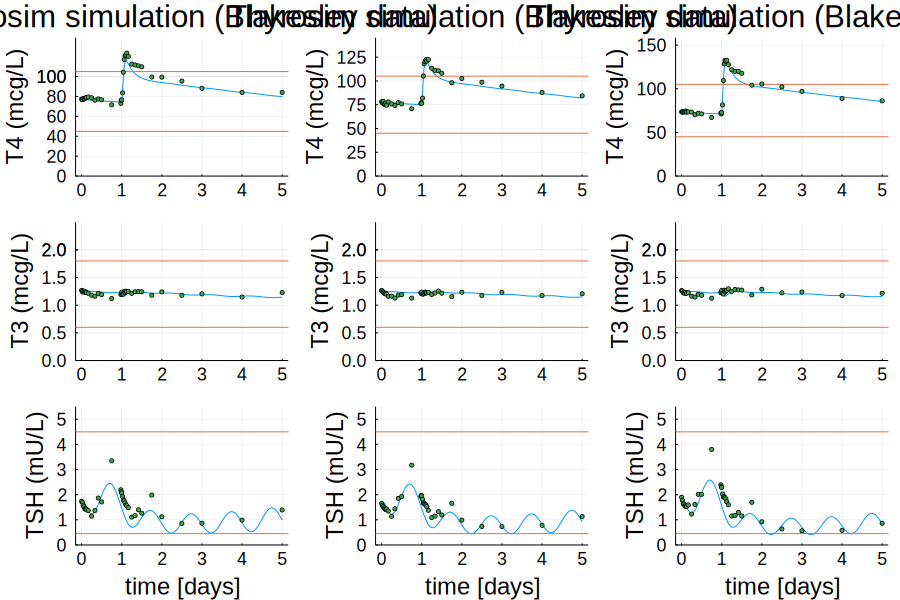

In [97]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = result.minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

## Check result by plotting (jonklaas)

In [2]:
Plots.scalefontsizes(1.5)

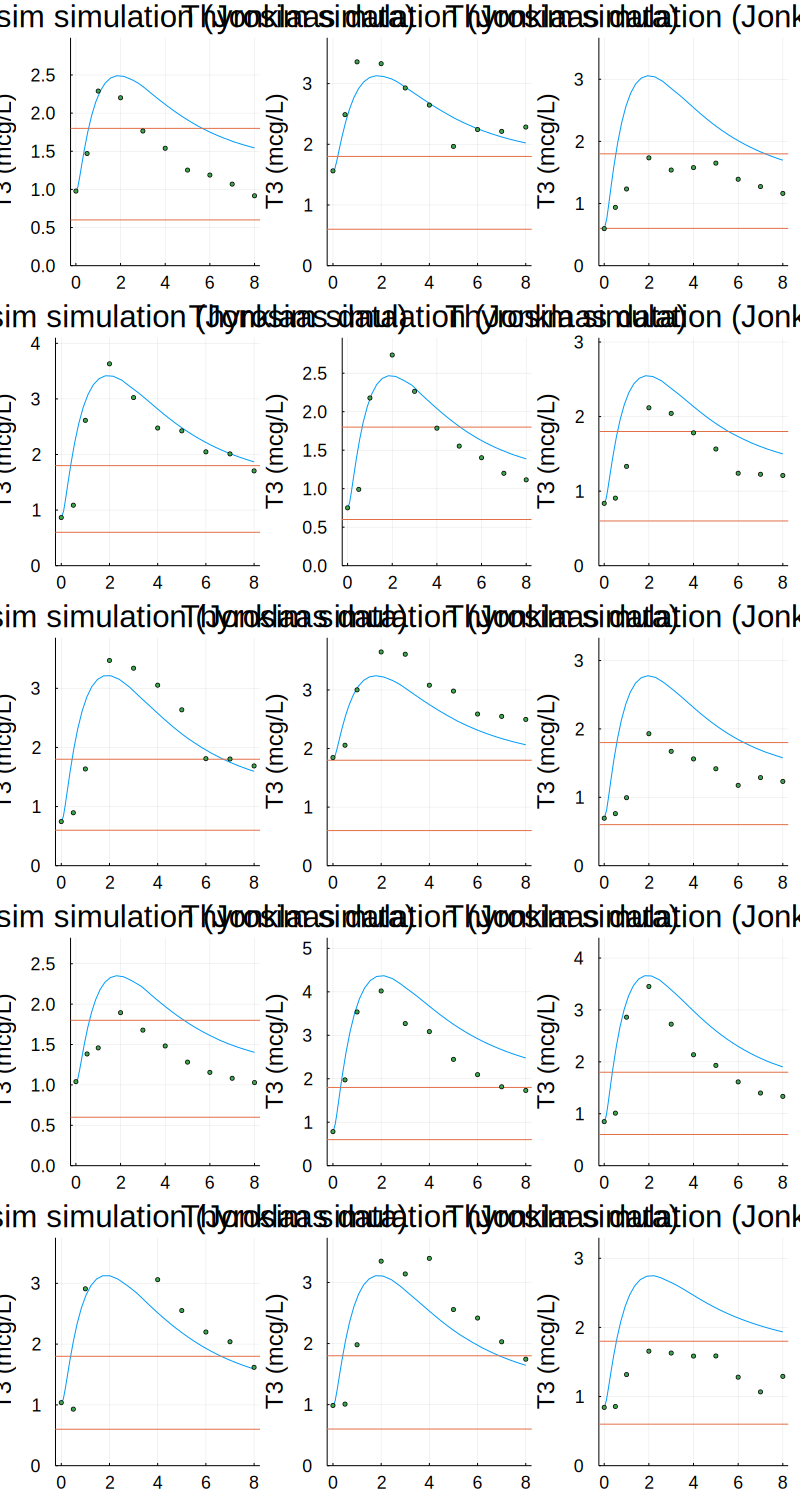

In [98]:
graphs = Vector{Any}(undef, 15)
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = result.minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas_T3only(sol, patient_t3[i, :])
end
plot(graphs..., layout=(5, 3), size=(800, 1500))

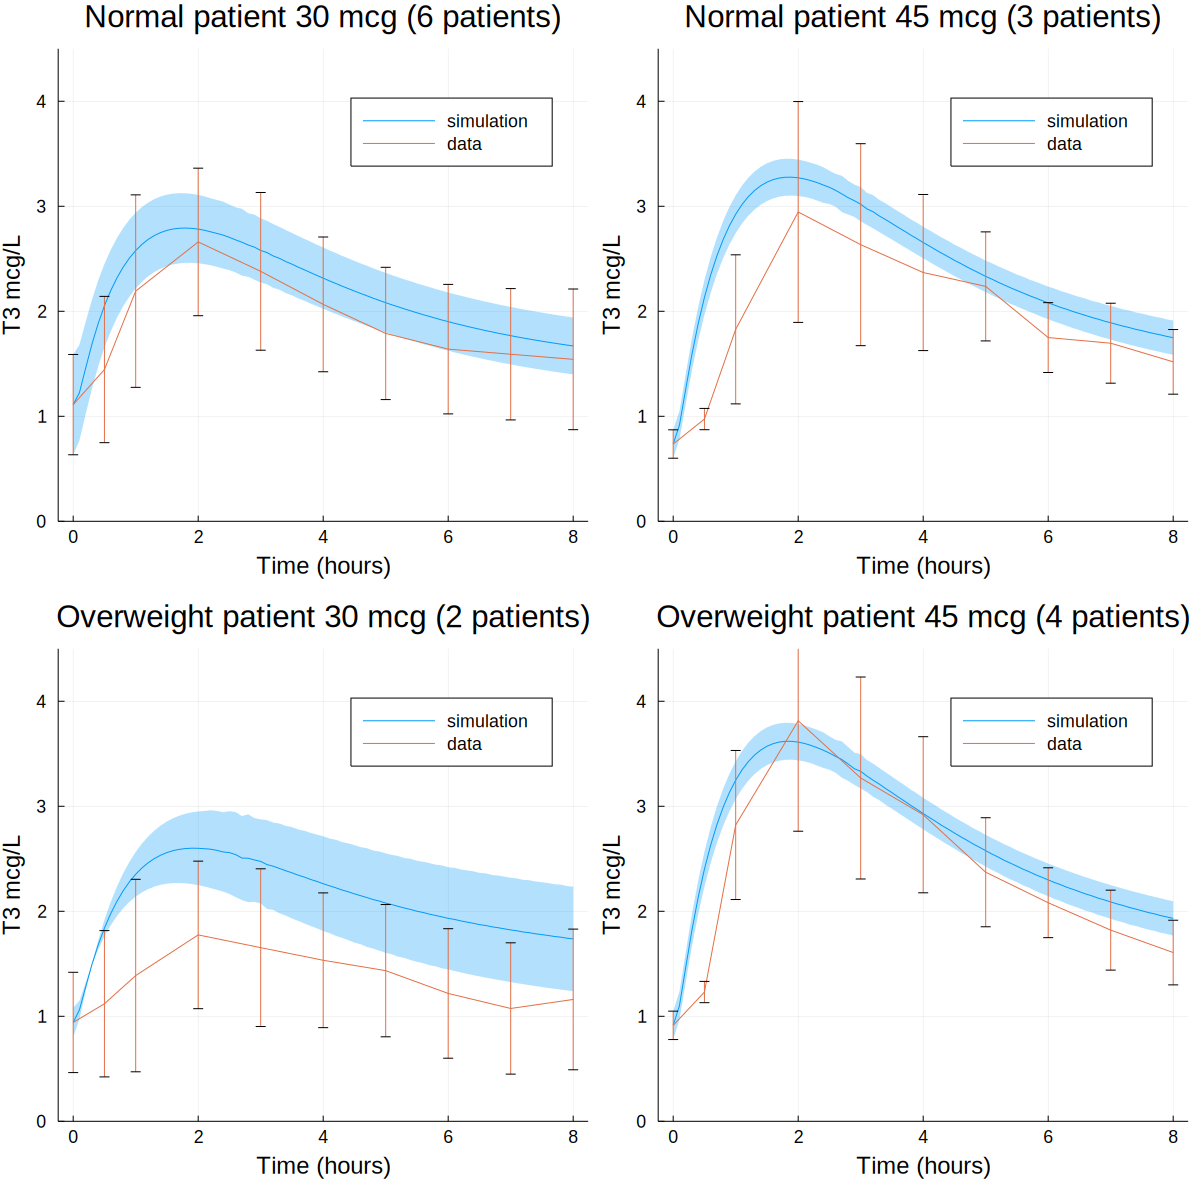

In [70]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = result.minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute sample standard deviations
    normal_45_T4_std = std.(normal_45_T4)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # mean and std of data
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2);

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal patient 45 mcg (3 patients)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal patient 30 mcg (6 patients)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight patient 45 mcg (4 patients)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight patient 30 mcg (2 patients)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()